In [3]:
import numpy as np
import datetime
import pandas as pd
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import torch
import math

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

Mounted at /content/drive
/content/drive/My Drive


In [5]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [6]:
AUDIO_FILE = './Zoom/'
keys_s = '1234567890qwertyuiopasdfghjklzxcvbnm'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

for i, File in enumerate(keys):
    loc = AUDIO_FILE + File
    samples, sample_rate = librosa.load(loc, sr=None)
    #samples = samples[round(1*sample_rate):]
    strokes = []
    prom = 0.06
    step = 0.005
    while not len(strokes) == 25:
        strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
        if len(strokes) < 25:
            prom -= step
        if len(strokes) > 25:
            prom += step
        if prom <= 0:
            print('-- not possible for: ',File)
            break
        step = step*0.99
    label = [labels[i]]*len(strokes)
    data_dict['Key'] += label
    data_dict['File'] += strokes

df = pd.DataFrame(data_dict)
mapper = {}
counter = 0
for l in df['Key']:
    if not l in mapper:
        mapper[l] = counter
        counter += 1
df.replace({'Key': mapper}, inplace=True)

In [ ]:
len(df['File'][0].numpy()[0])

14400

In [7]:
# Reshaping data into grid
data = pd.DataFrame()

for i in range(len(df)):
    # Extract singal values, normalise, reshape
    signal_np = df['File'][i].numpy()[0]
    normalised = signal_np / 255.0
    reshaped_signal = normalised.reshape(120, 120)

    # Temporary df to hold values then concatenate
    temp_df = pd.DataFrame({'x': [reshaped_signal], 'y': [df['Key'][i]]})
    data = pd.concat([data, temp_df], ignore_index=True)

data['y'] = data['y'].astype(int)  # int dtype for labels

In [ ]:
data.shape

(900, 2)

In [ ]:
data['x'].shape

(900,)

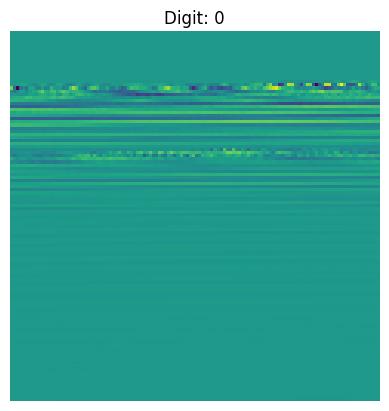

In [ ]:
for i in range(10):
    plt.imshow(data['x'][i])
    plt.title("Digit: " + str(data['y'][i]))
    plt.axis('off')

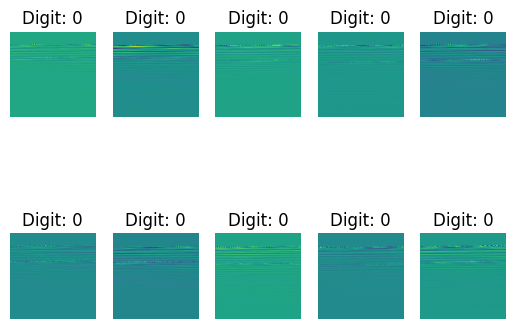

In [ ]:
# Plot images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data['x'][i])
    plt.title("Digit: " + str(data['y'][i]))
    plt.axis('off')

<ipython-input-5-549d51999613>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 2))


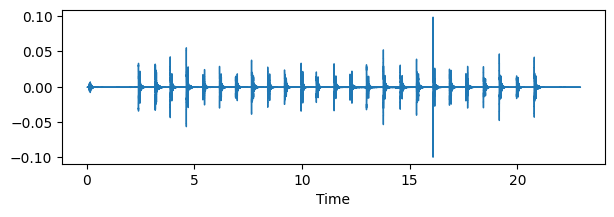

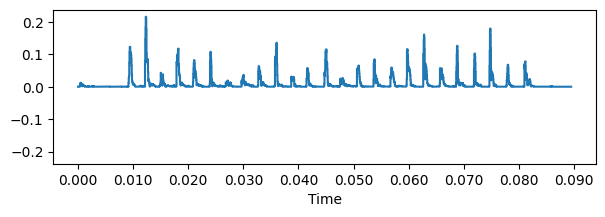

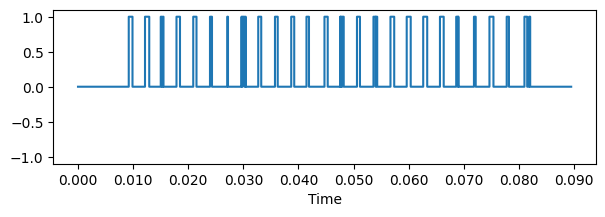

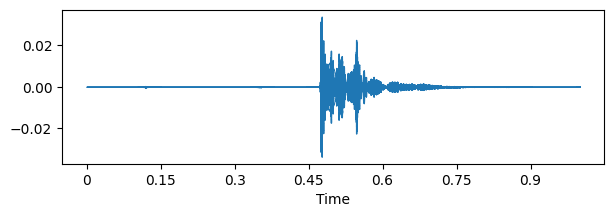

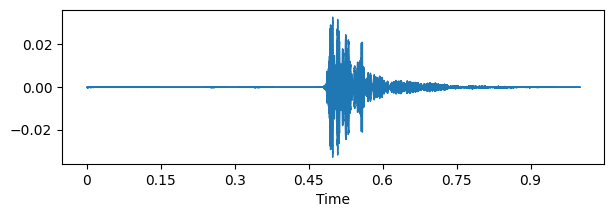

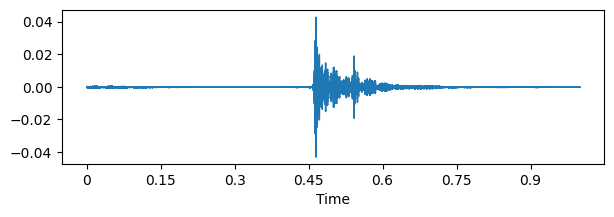

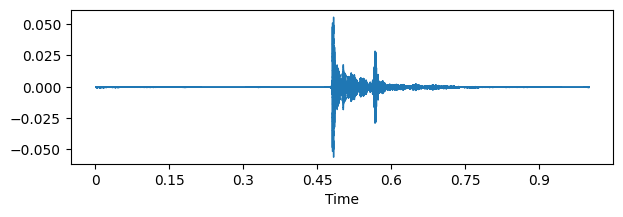

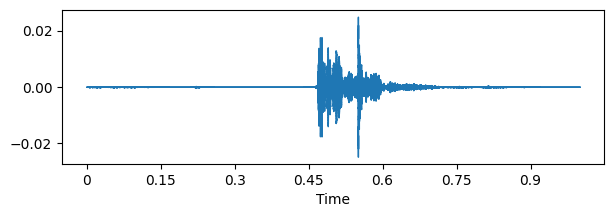

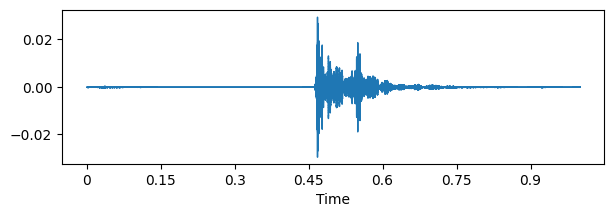

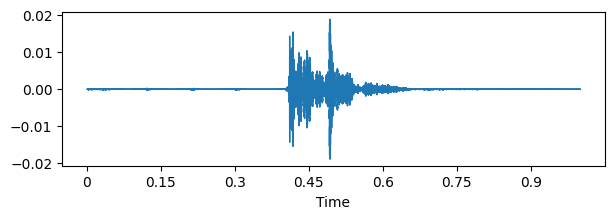

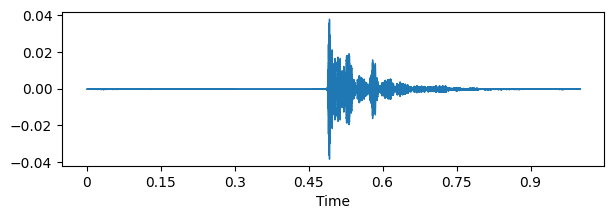

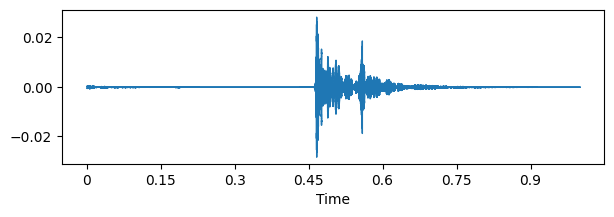

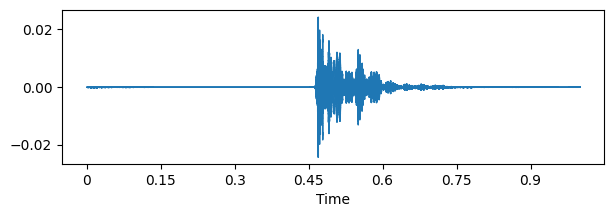

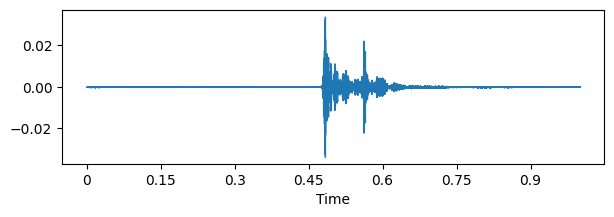

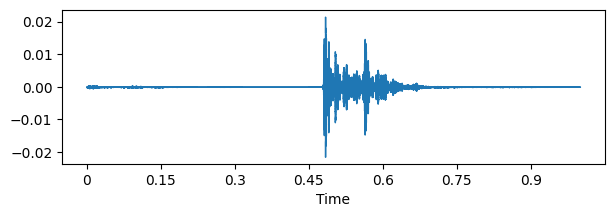

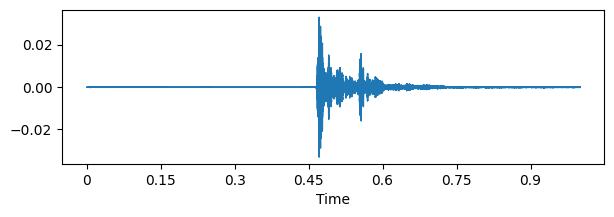

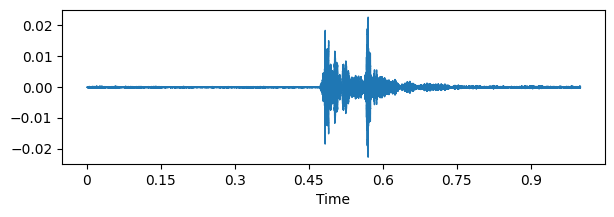

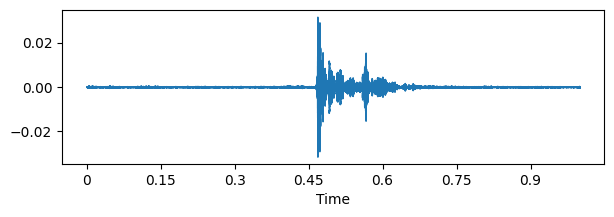

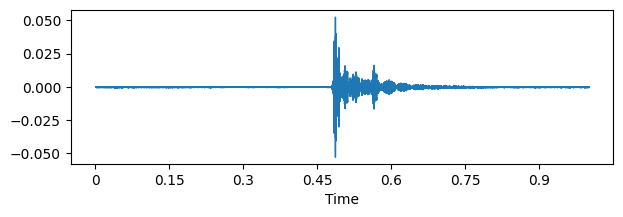

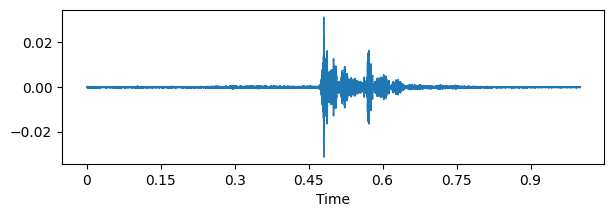

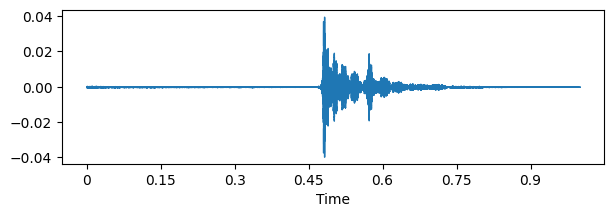

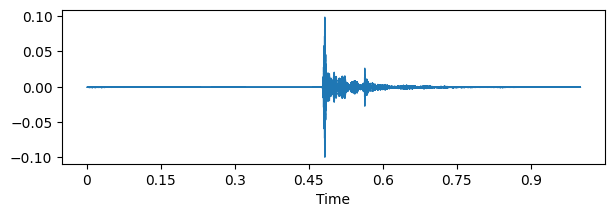

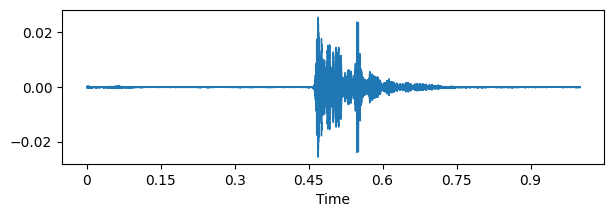

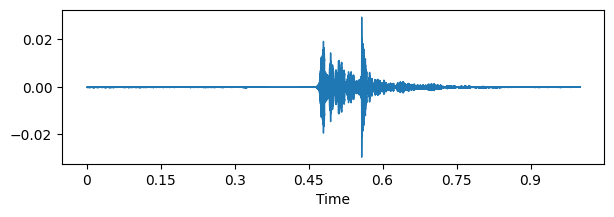

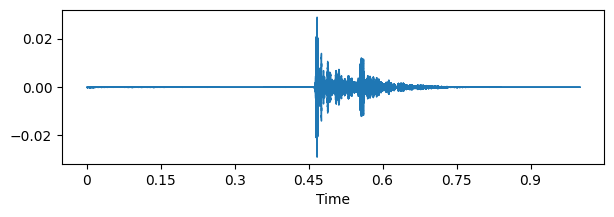

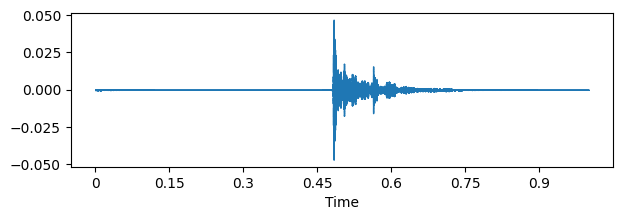

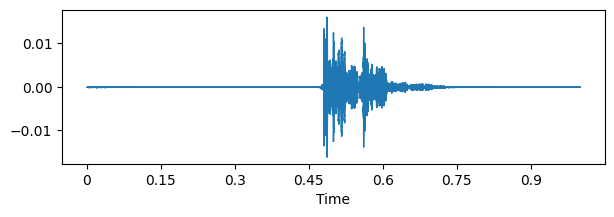

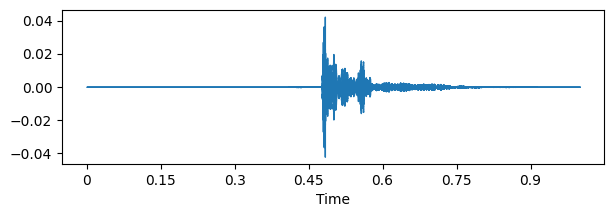

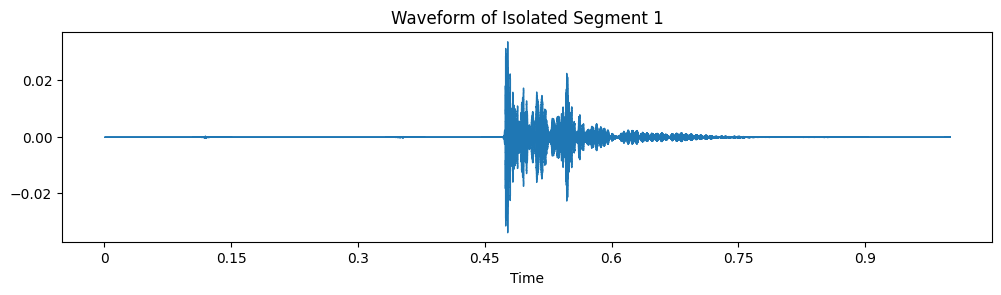

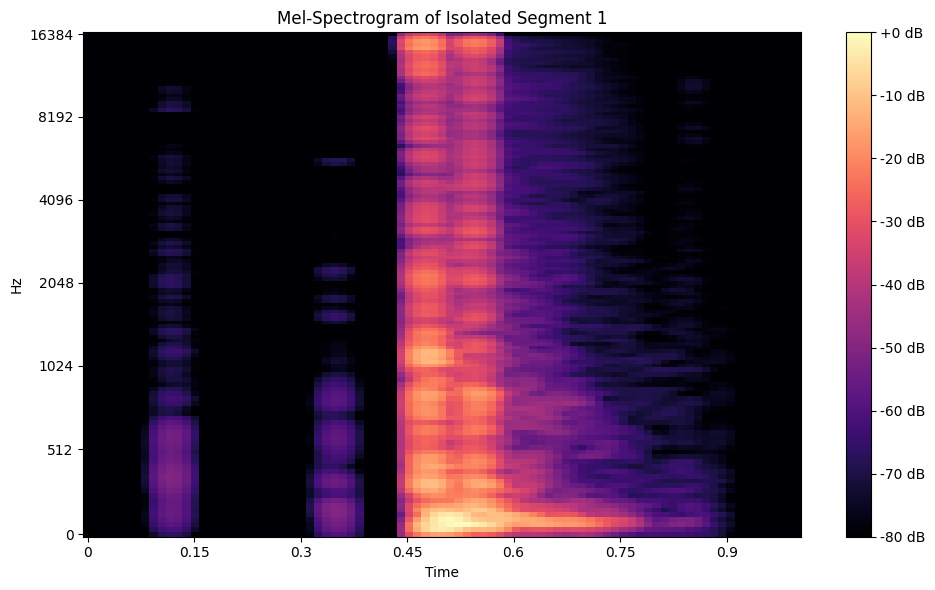

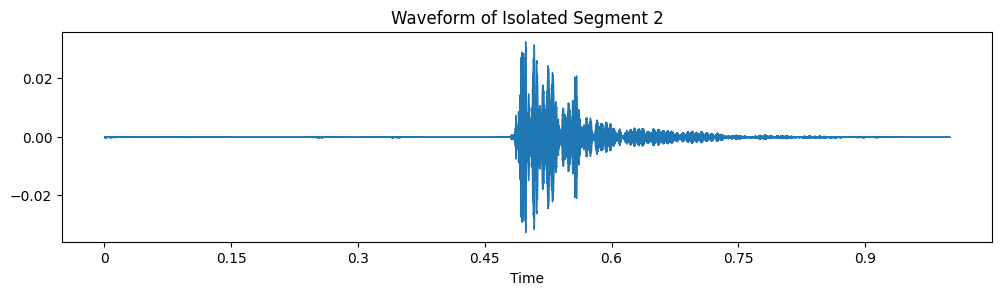

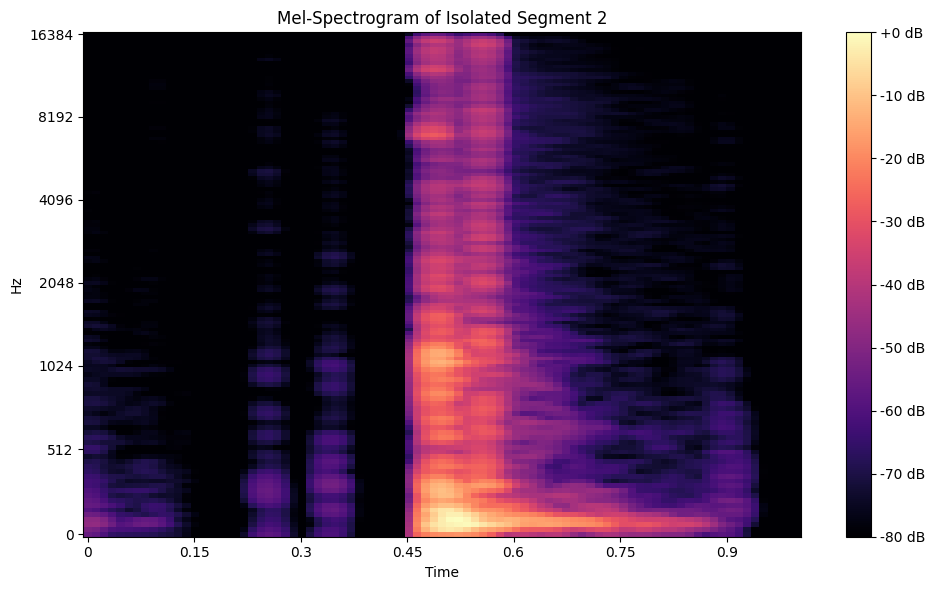

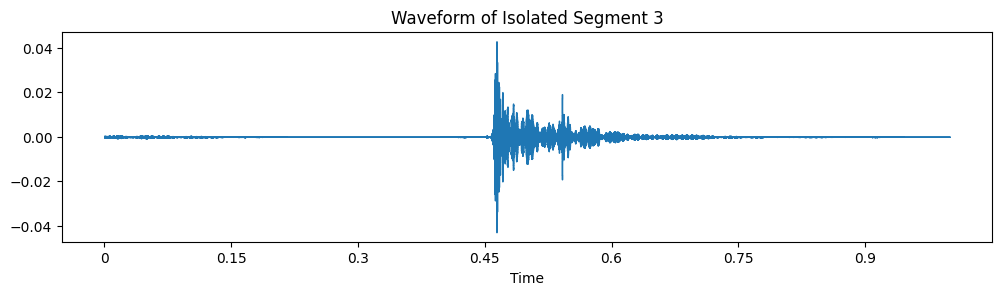

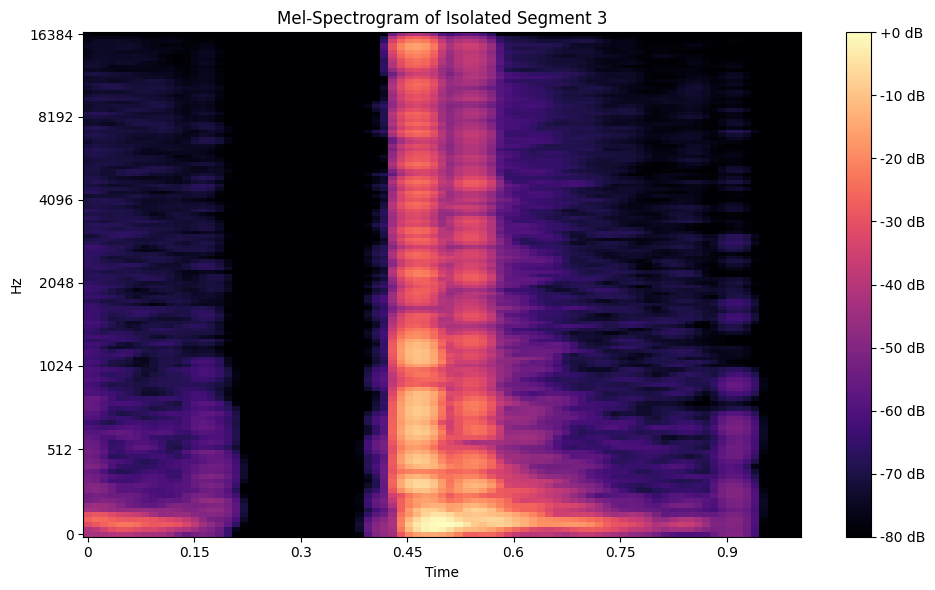

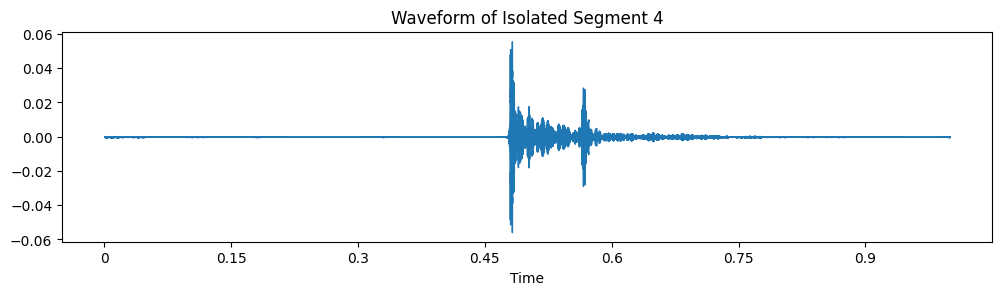

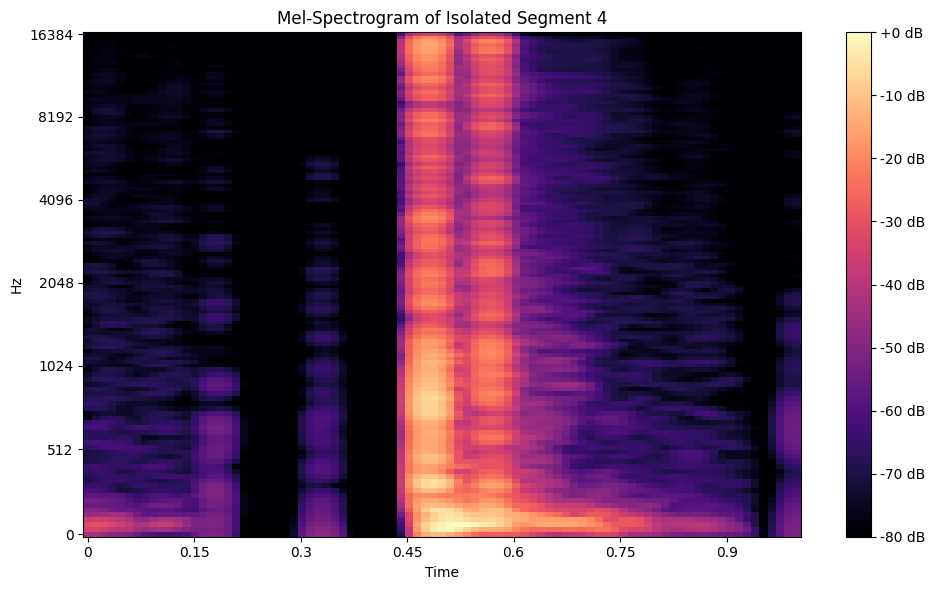

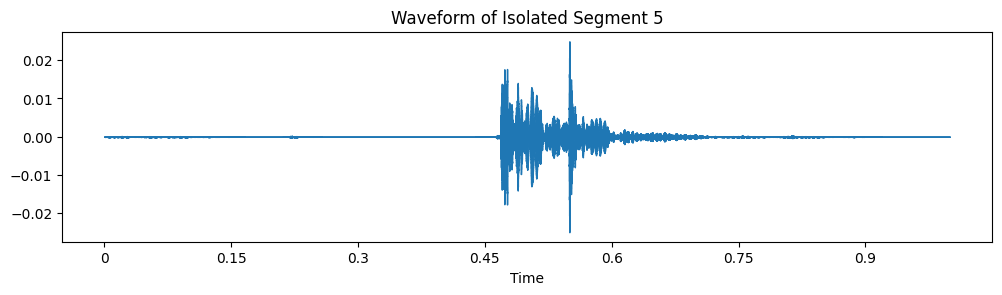

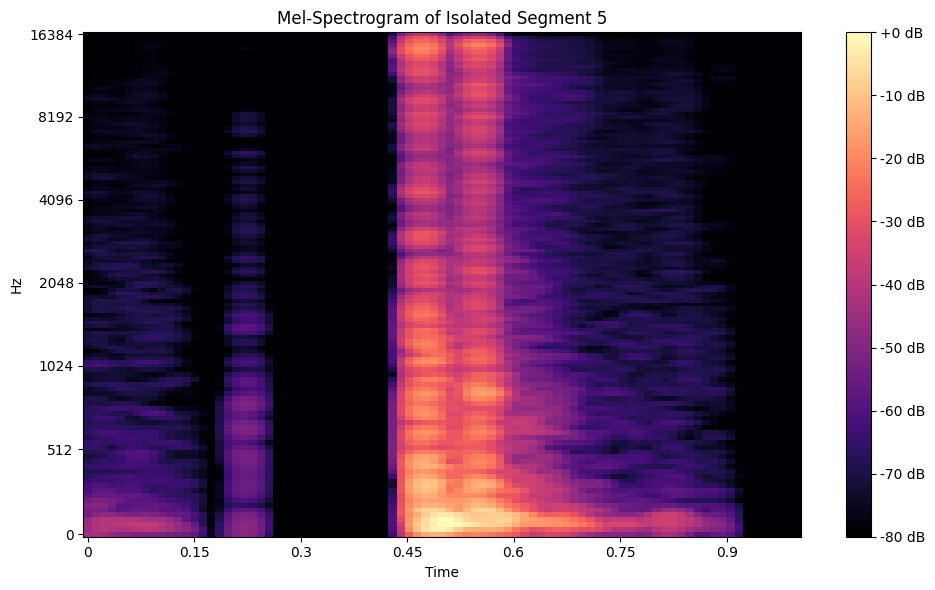

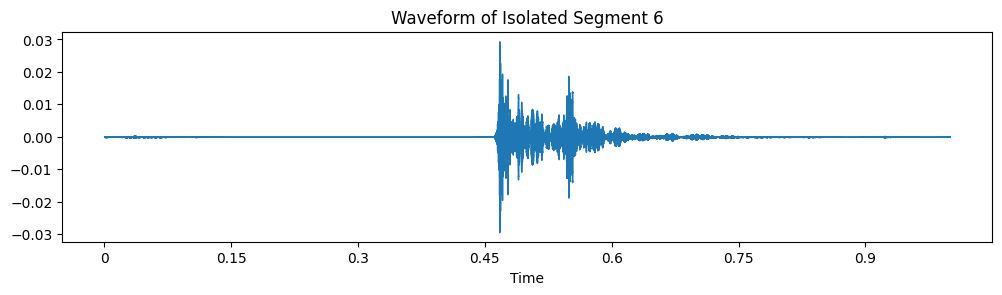

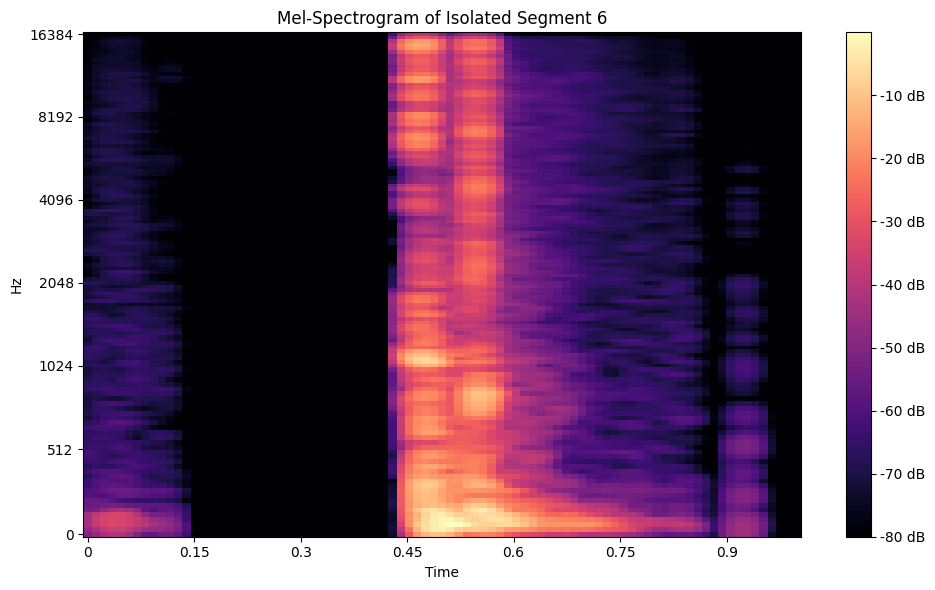

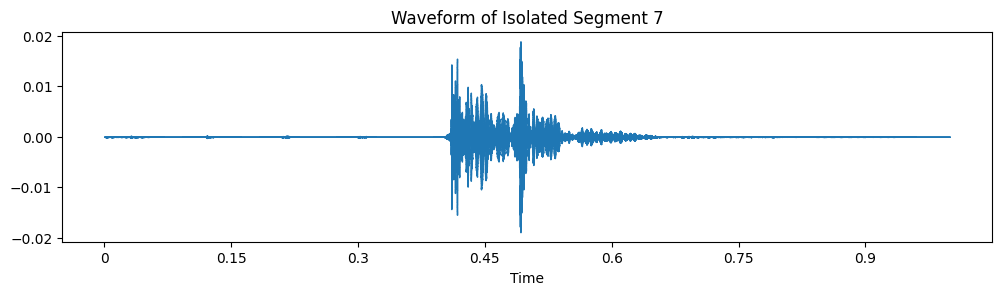

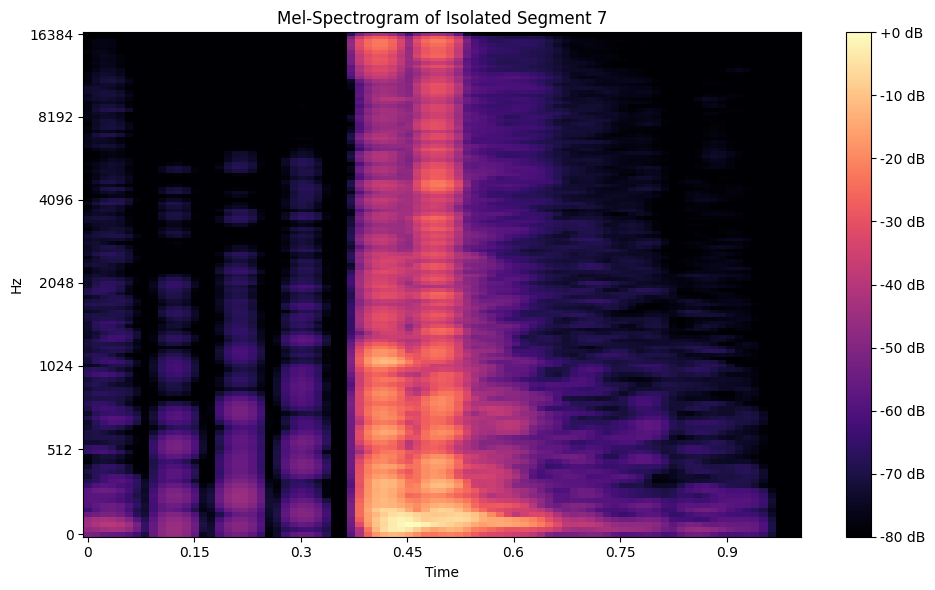

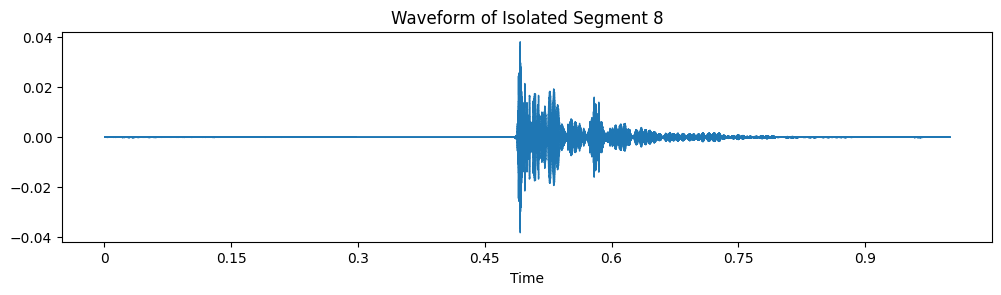

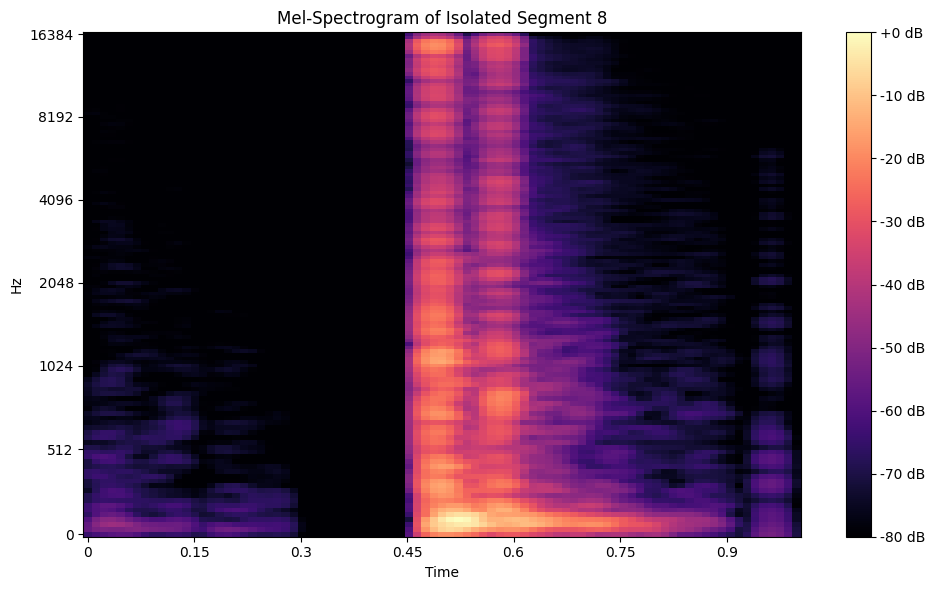

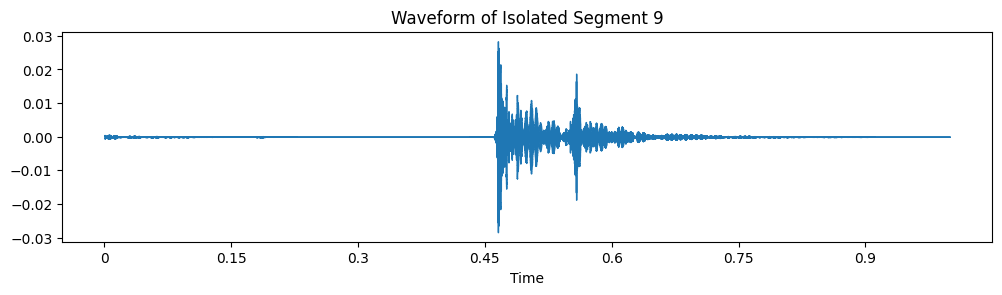

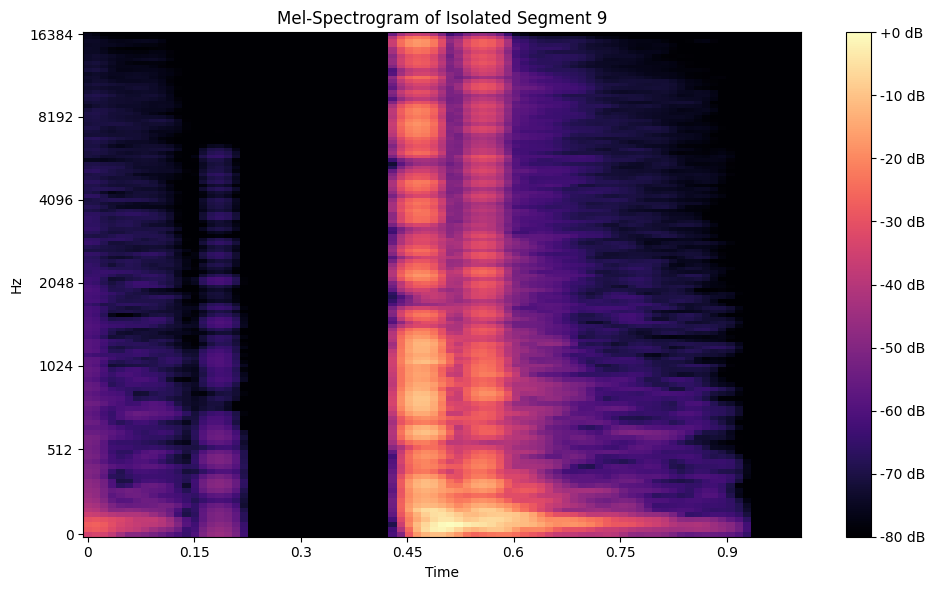

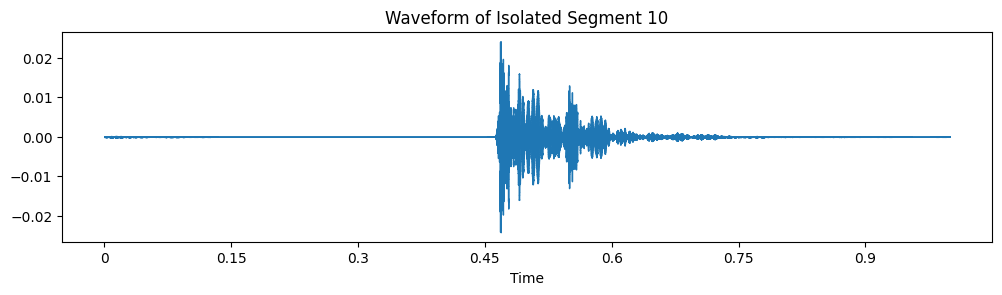

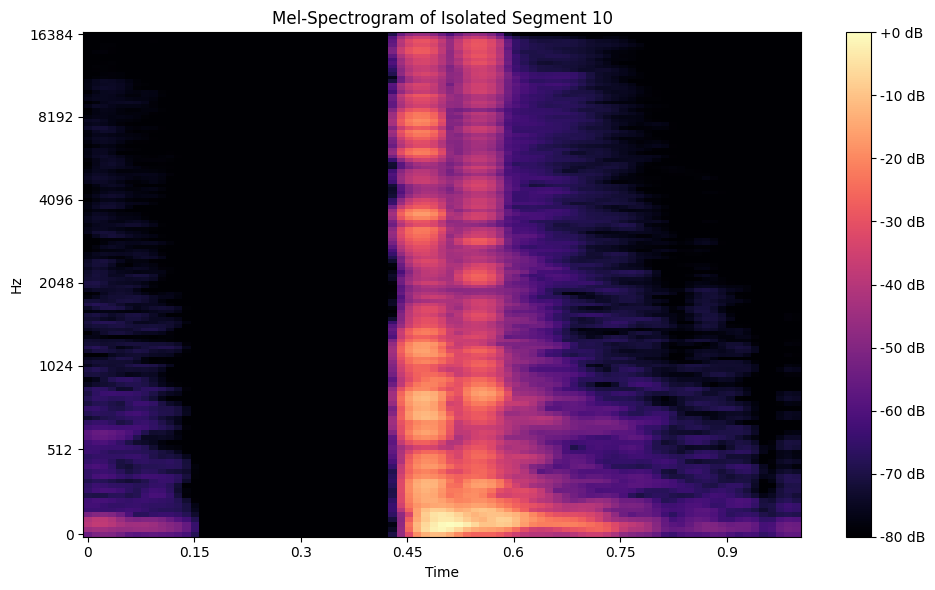

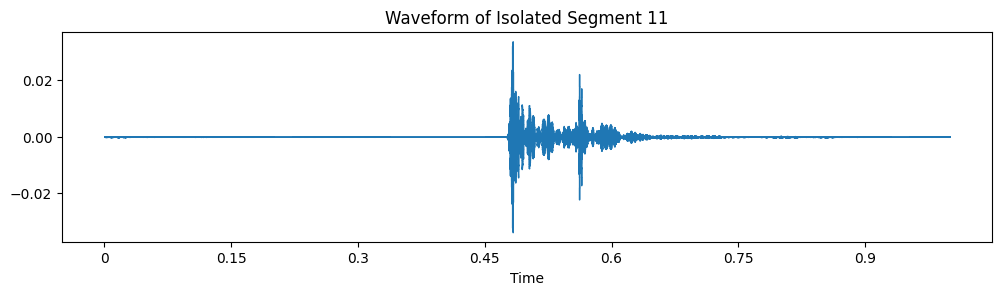

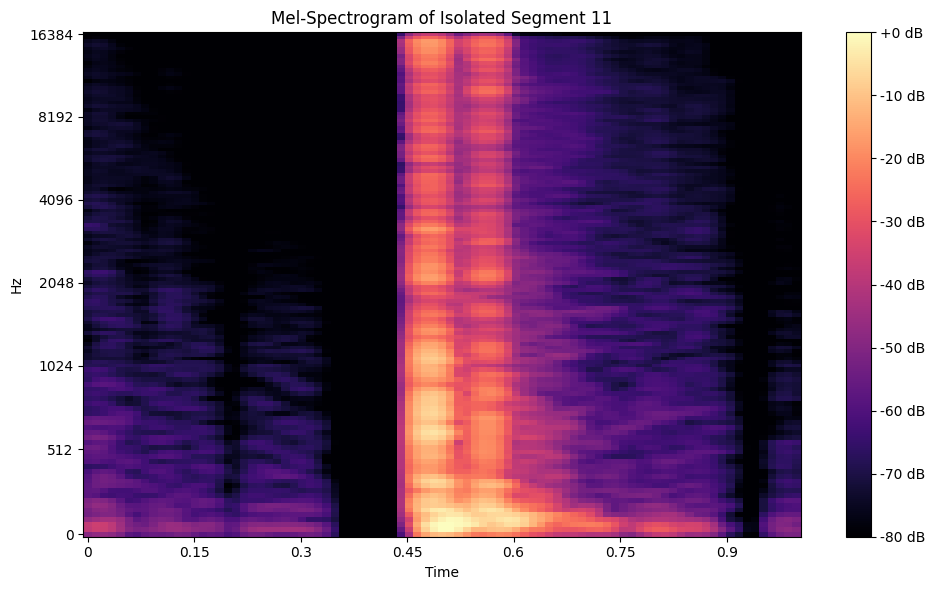

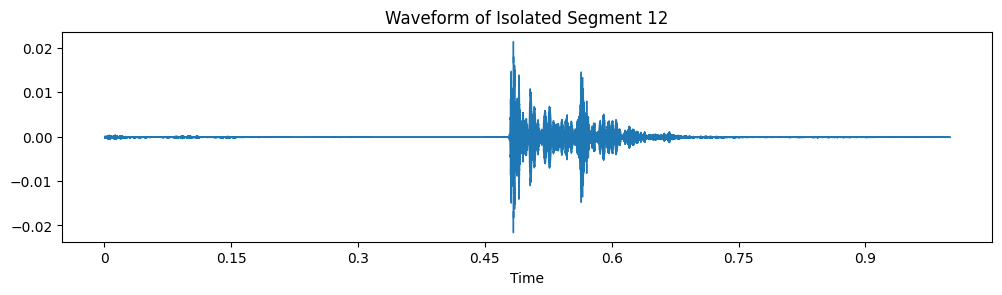

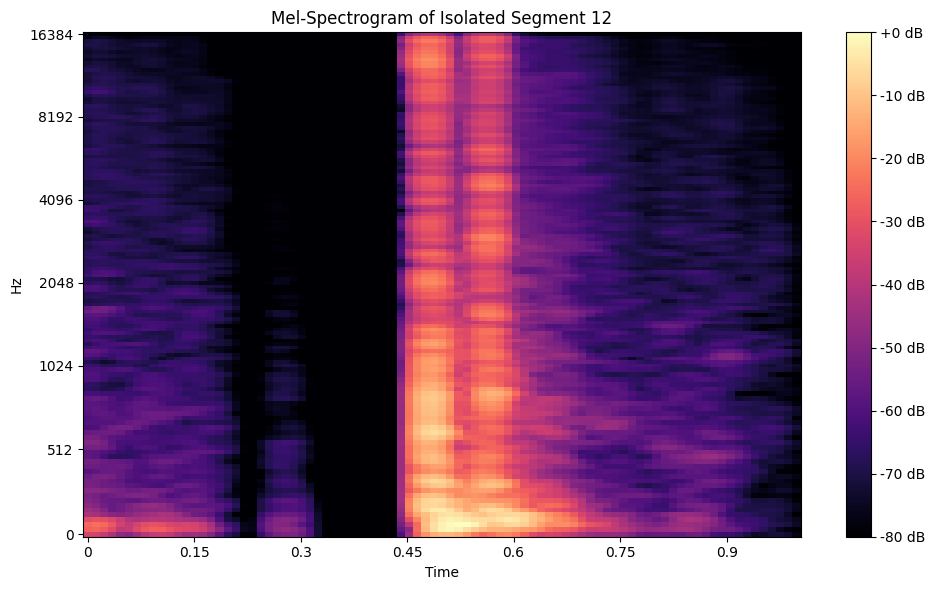

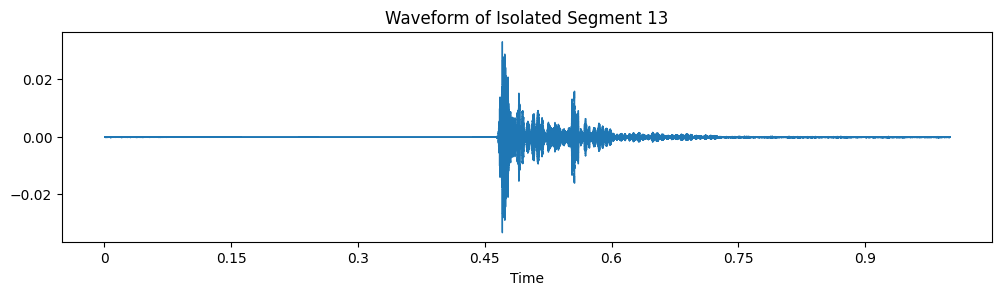

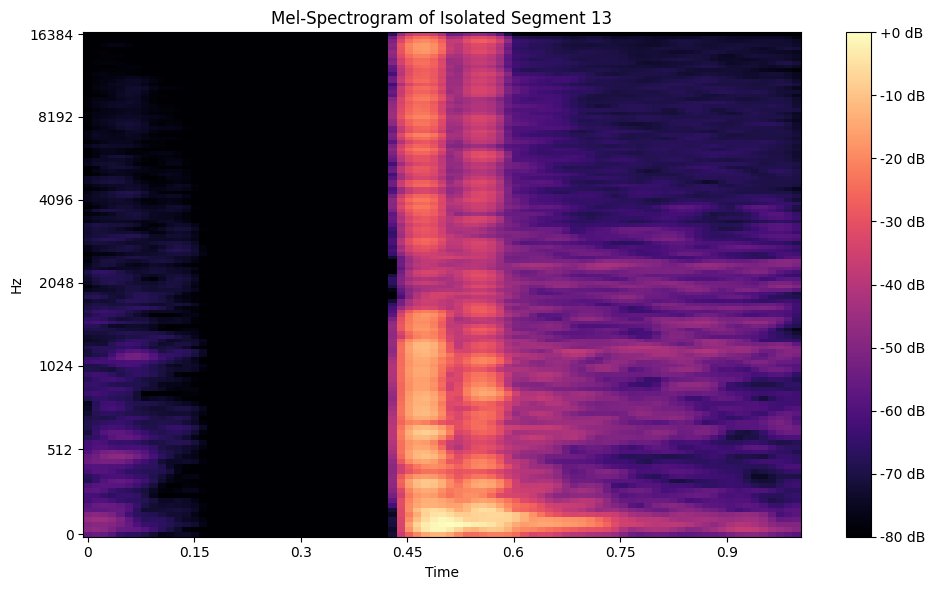

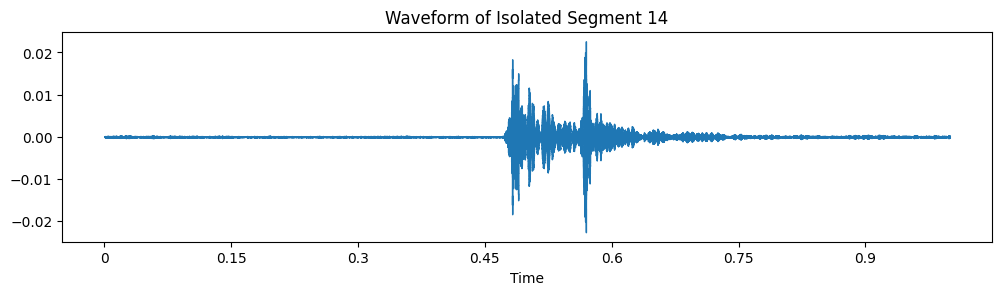

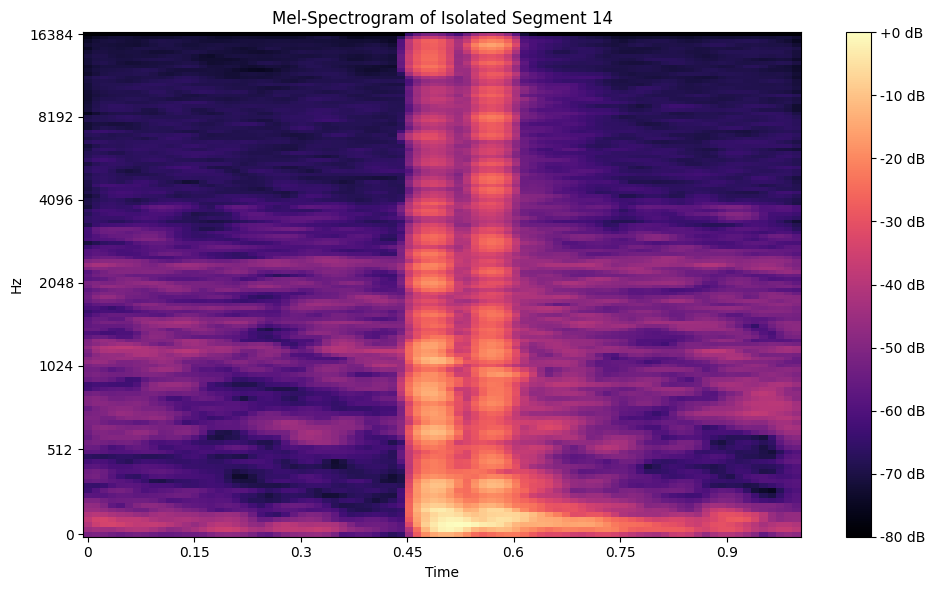

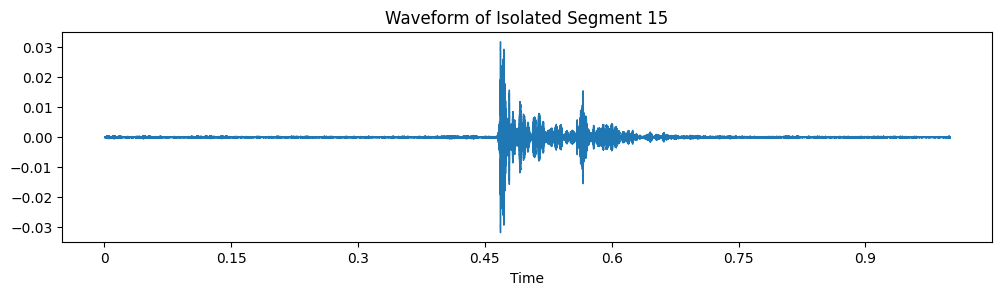

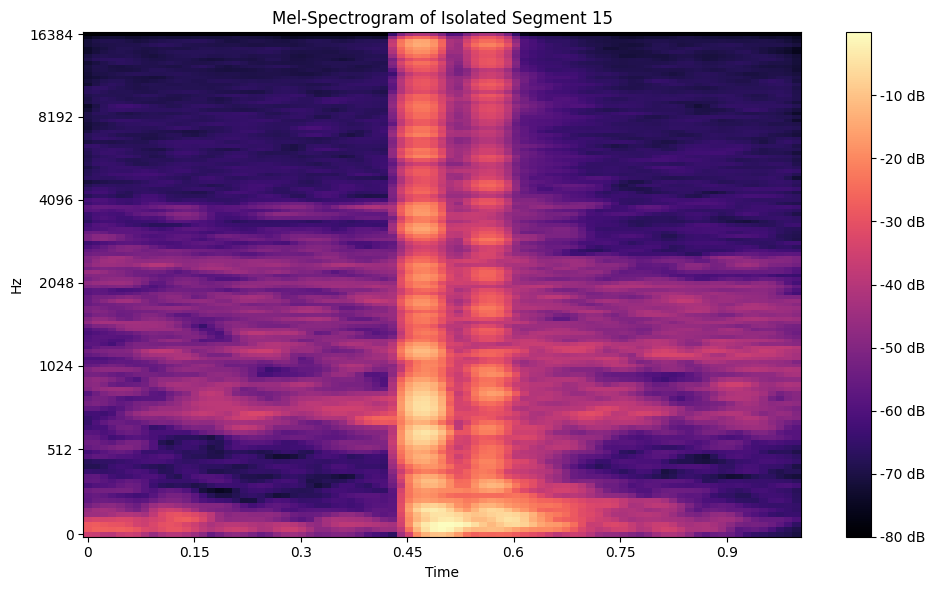

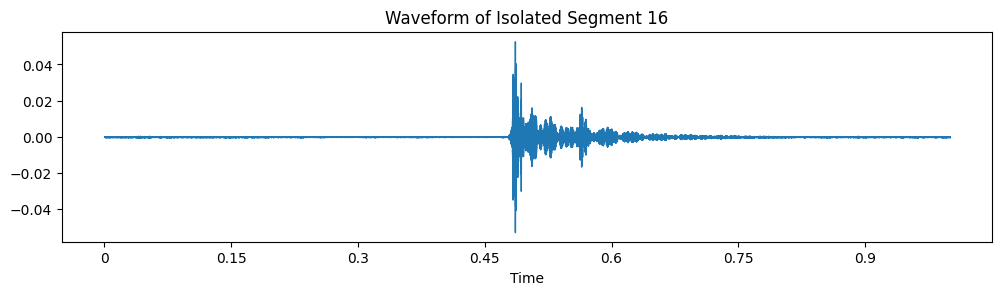

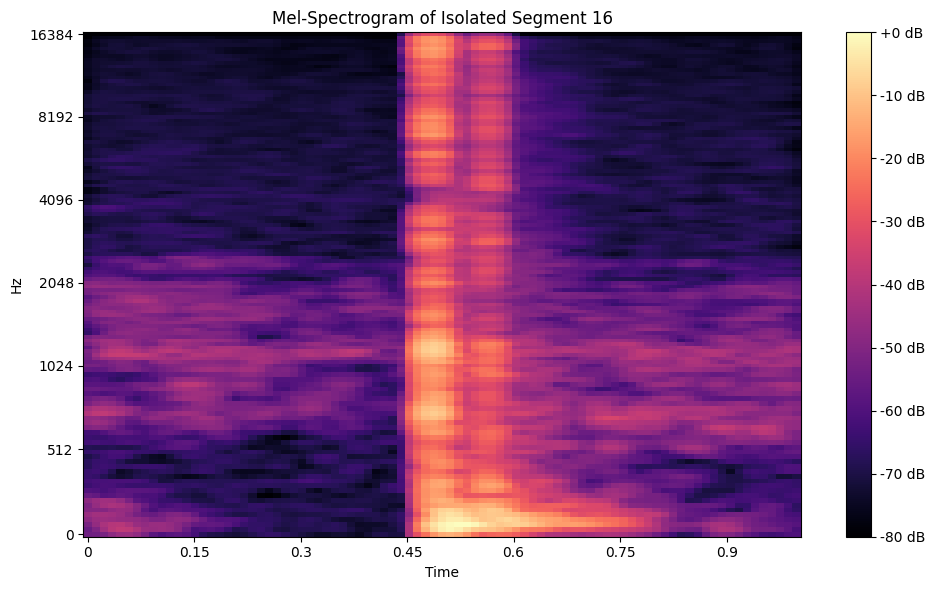

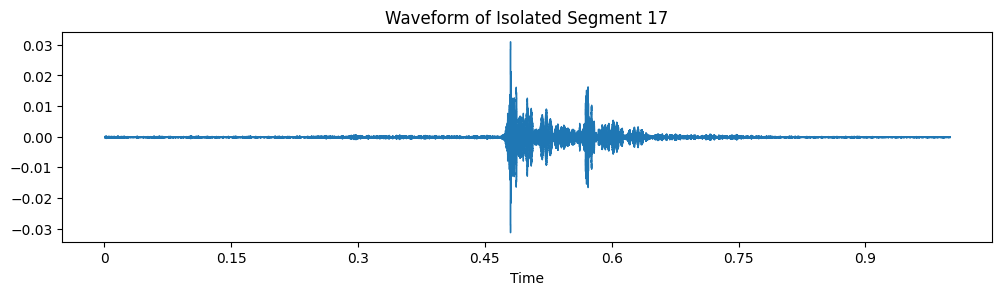

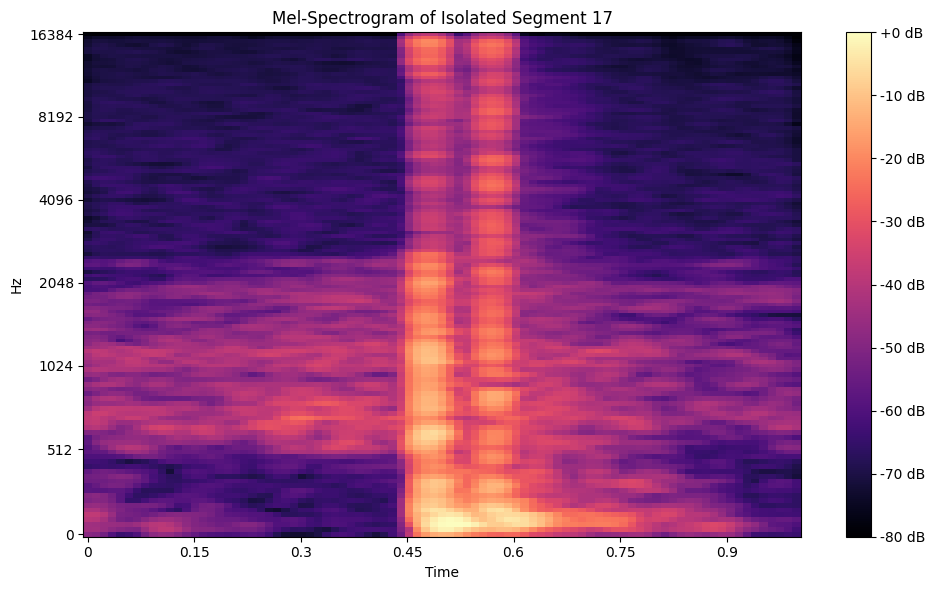

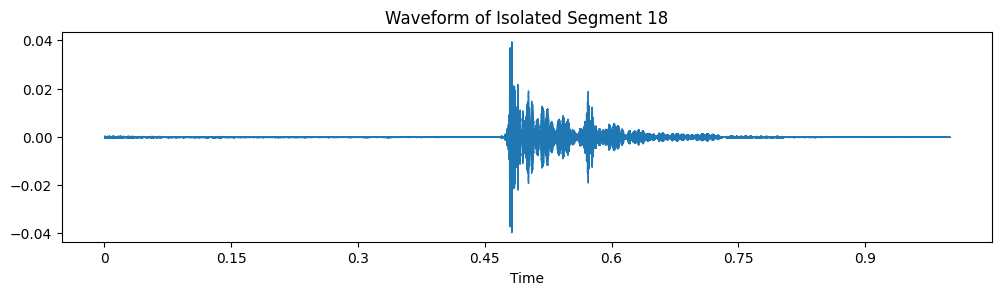

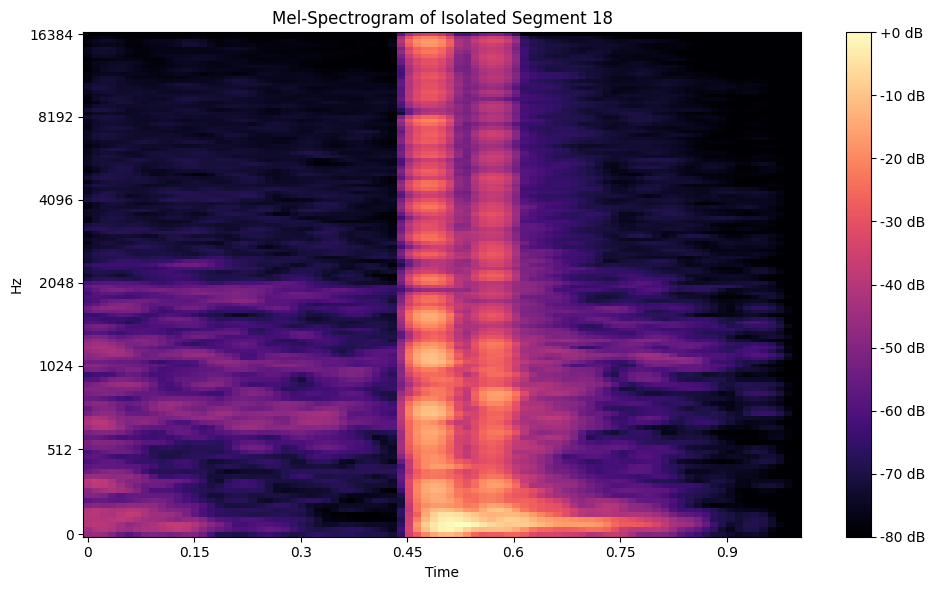

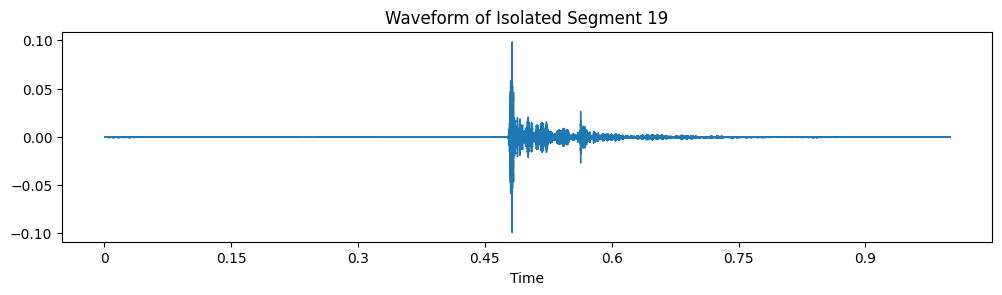

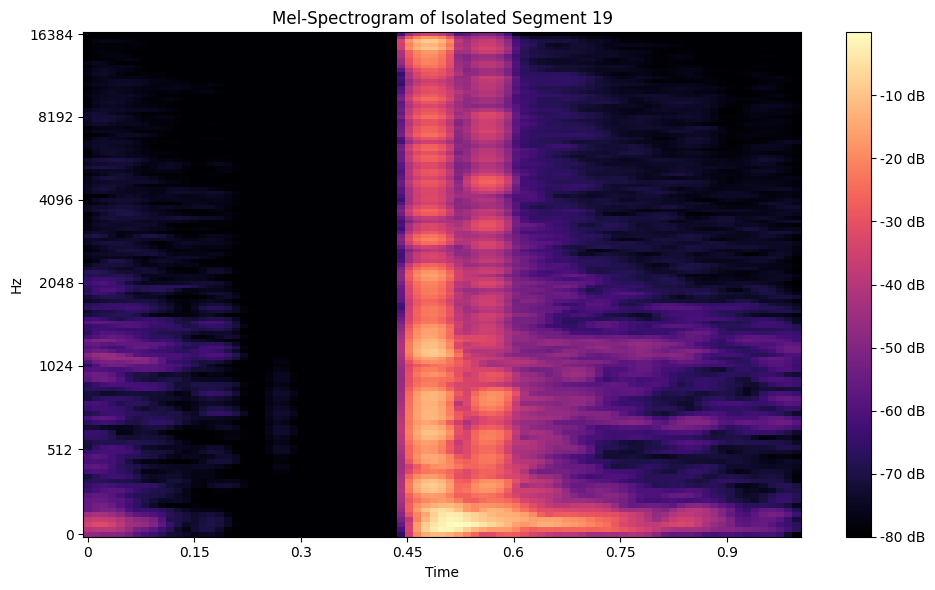

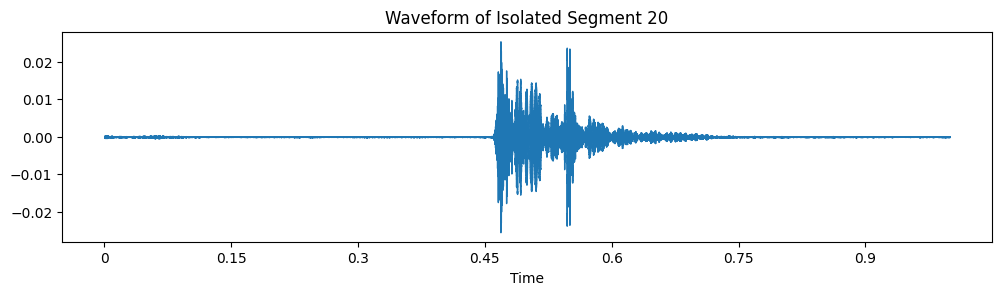

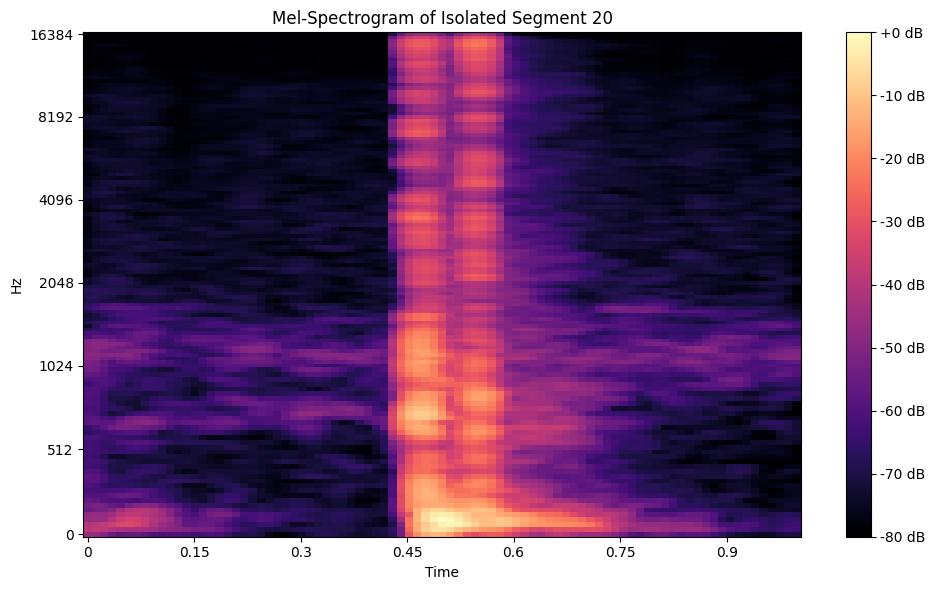

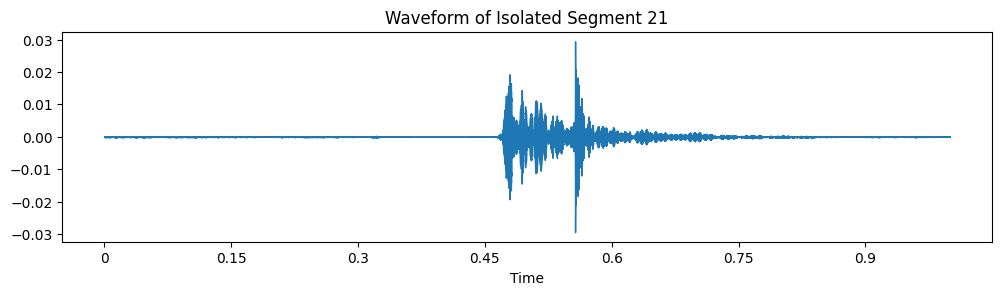

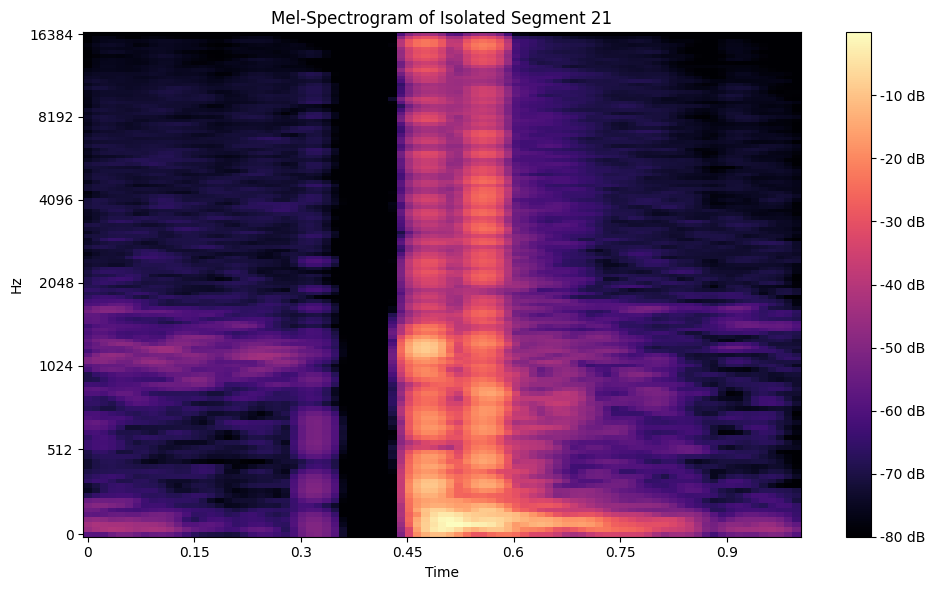

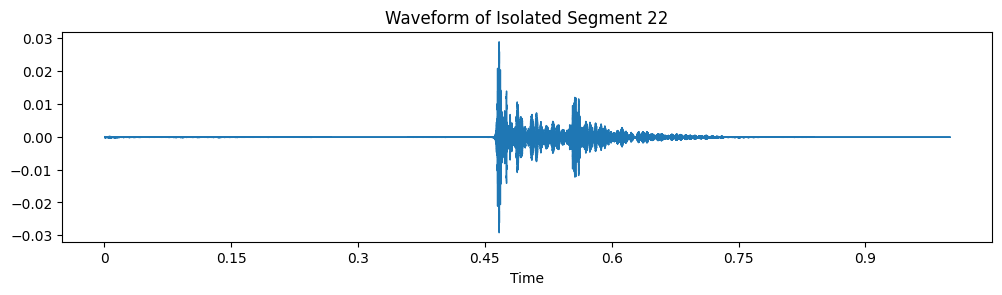

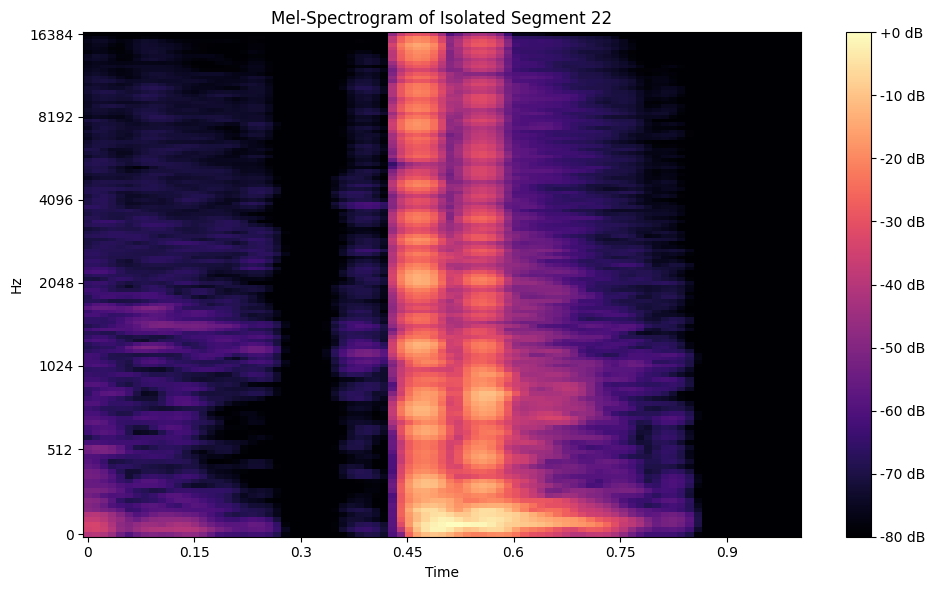

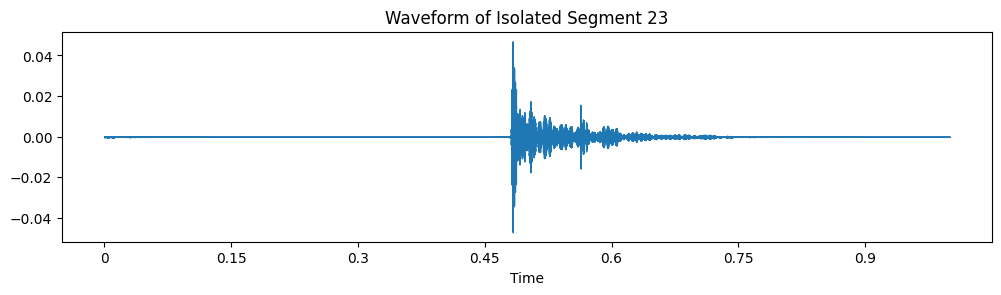

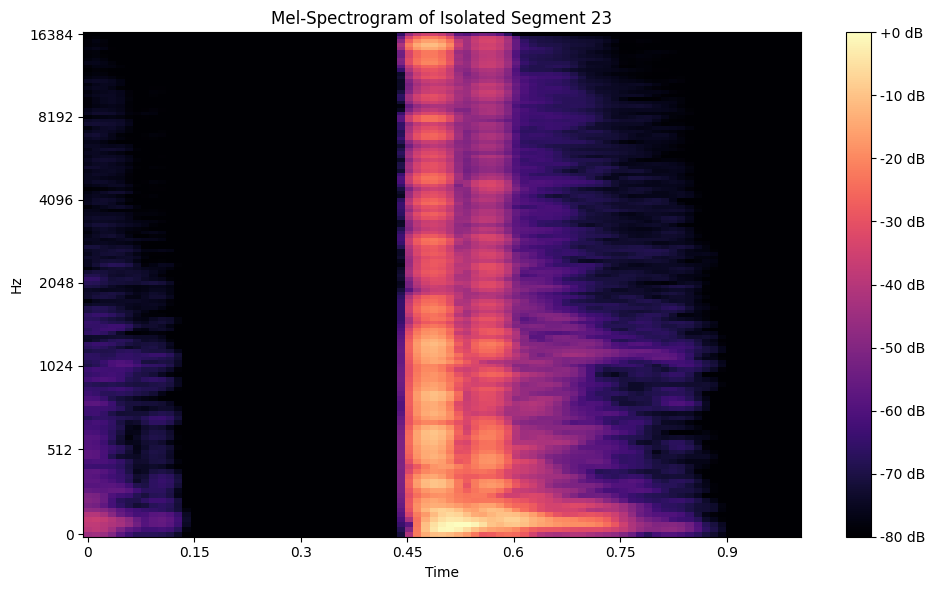

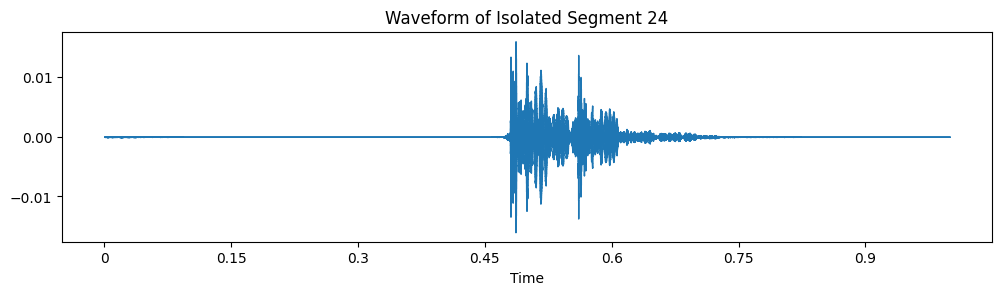

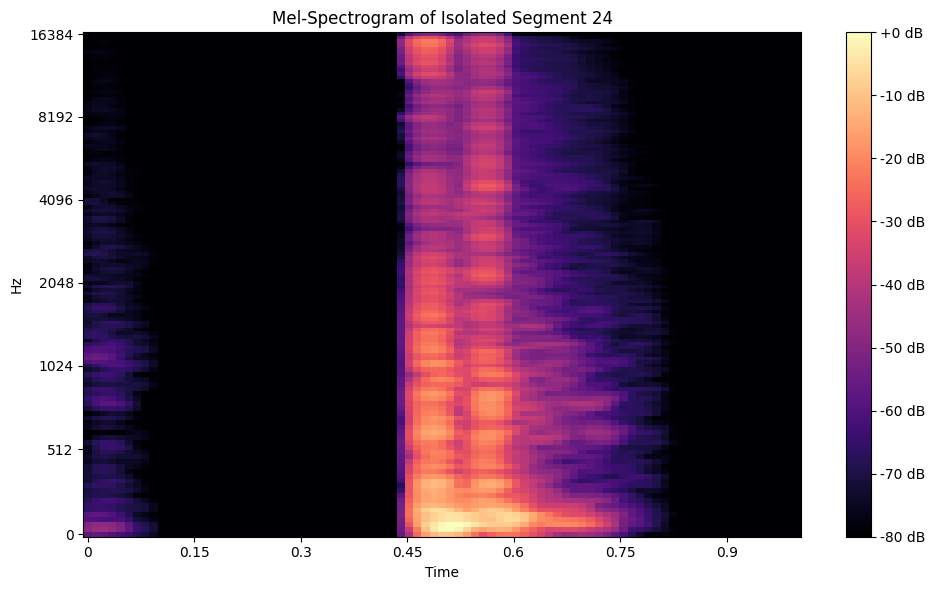

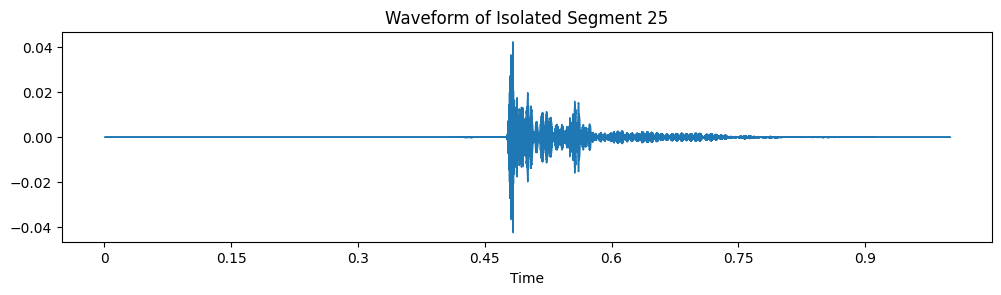

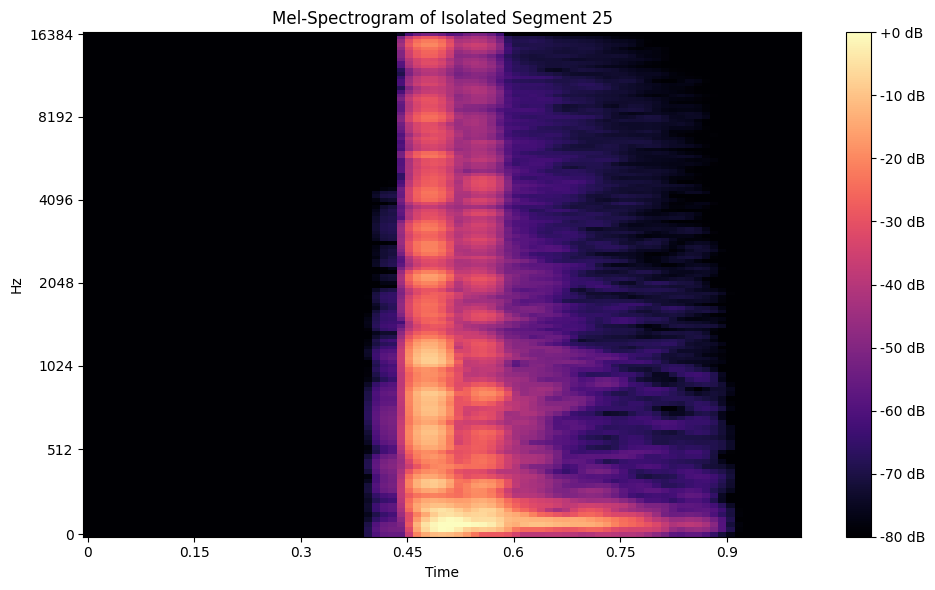

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch  # Ensure torch is imported if you're using it

# Your isolator function here

# Load the audio signal
signal, sample_rate = librosa.load('/content/1.wav')  # Ensure the path is correct

# Parameters
size = 2048  # FFT size
scan = 256  # Hop length for FFT
before = int(0.5 * sample_rate)  # Convert to samples
after = int(0.5 * sample_rate)  # Convert to samples
threshold = 0.015  # Threshold for detecting peaks
show = True  # Set to True to visualize the process

# Apply the isolator function
strokes = isolator(signal, sample_rate, size, scan, before, after, threshold, show)

# Initialize a list to store Mel-spectrograms
mel_spectrograms = []

# Plotting the waveforms and mel-spectrograms for each isolated segment
for i, stroke in enumerate(strokes):
    stroke_np = stroke.detach().numpy().flatten()  # Convert torch tensor to numpy array and flatten if needed

    # Compute mel-spectrogram
    S = librosa.feature.melspectrogram(y=stroke_np, sr=sample_rate, n_fft=size, hop_length=scan)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Store the mel-spectrogram array
    mel_spectrograms.append(S_DB)

    # If visualization is enabled, plot waveform and mel-spectrogram
    if show:
        # Plot waveform
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(stroke_np, sr=sample_rate)
        plt.title(f'Waveform of Isolated Segment {i+1}')

        # Plot mel-spectrogram
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(S_DB, sr=sample_rate, hop_length=scan, x_axis='time', y_axis='mel', fmax=16384)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram of Isolated Segment {i+1}')
        plt.tight_layout()
        plt.show()

# Now, `mel_spectrograms` is a list that contains all the Mel-spectrogram arrays.
# You can use this list to feed your deep learning model.


In [19]:
mel_spectrograms

[array([[-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        ...,
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.],
        [-80., -80., -80., ..., -80., -80., -80.]], dtype=float32),
 array([[-55.568405, -56.788223, -60.69719 , ..., -80.      , -80.      ,
         -80.      ],
        [-52.00869 , -53.086708, -56.729702, ..., -80.      , -80.      ,
         -80.      ],
        [-47.41349 , -47.11901 , -49.203163, ..., -80.      , -80.      ,
         -80.      ],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ]], dtype=float32),
 array([[-43.02875 , -42.861576, -42.4251  , ..., -80.    

In [17]:
len(mel_spectrograms)

25

In [18]:
mel_spectrograms[1].shape

(128, 87)